###  Projet : Fashion Trend Intelligence

####  Objectif du projet
Ce projet vise à évaluer la performance d’un modèle de segmentation d'images de vêtements. L’objectif est de prédire des masques segmentés par catégorie et de mesurer la qualité des prédictions via des métriques.

#### Contexte
Le modèle utilisé ici est basé sur le modèle `segformer_b3_clothes`, hébergé sur HuggingFace. Il s’agit d’un modèle pré-entraîné.

Auteur : Christophe Ringot  
Date : 25-06-2025


### 1. Import des modules necessaires

In [1]:
from dotenv import load_dotenv, dotenv_values
import matplotlib.pyplot as plt
import os, io, base64, requests
from tqdm import tqdm
from PIL import Image
import numpy as np
import time

### 2. Chargement des variables d'environnement depuis le `.env`  

In [2]:
load_dotenv()
config = dotenv_values(".env")

### 3. Déclaration des variables


In [3]:
image_dir = "./assets/top_influenceurs_2024/IMG/"
mask_dir = "./assets/top_influenceurs_2024/Mask/"
max_images = 3  
api_token = os.getenv("API_TOKEN")
url = "https://api-inference.huggingface.co/models/sayeed99/segformer_b3_clothes"
headers = {
    "Authorization": f"Bearer {api_token}",
    "Content-Type": "image/png"
}
image_paths = []
mask_paths = []
combined_masks = []

### 4. Fonctions Utilitaires pour le Traitement des Masques

Le modèle que nous utilisons (`sayeed99/segformer_b3_clothes`) renvoie des masques pour différentes classes (cheveux, chapeau, etc.). Ces masques sont encodés en base64. Les fonctions ci-dessous sont fournies pour vous aider à :
1.  `CLASS_MAPPING`: Un dictionnaire qui associe les noms de classes (ex: "Hat") à des identifiants numériques.
2.  `get_image_dimensions`: Récupérer les dimensions d'une image.
3.  `decode_base64_mask`: Décoder un masque de base64 en une image (tableau NumPy) et le redimensionner.
4.  `create_masks`: Combiner les masques de toutes les classes détectées en un seul masque de segmentation final, où chaque pixel a la valeur de l'ID de sa classe.

In [4]:
CLASS_MAPPING = {
    "Background": 0,
    "Hat": 1,
    "Hair": 2,
    "Sunglasses": 3,
    "Upper-clothes": 4,
    "Skirt": 5,
    "Pants": 6,
    "Dress": 7,
    "Belt": 8,
    "Left-shoe": 9,
    "Right-shoe": 10,
    "Face": 11,
    "Left-leg": 12,
    "Right-leg": 13,
    "Left-arm": 14,
    "Right-arm": 15,
    "Bag": 16,
    "Scarf": 17
}



def get_image_dimensions(img_path):
    """
    Get the dimensions of an image.

    Args:
        img_path (str): Path to the image.

    Returns:
        tuple: (width, height) of the image.
    """
    original_image = Image.open(img_path)
    return original_image.size

def decode_base64_mask(base64_string, width, height):
    """
    Decode a base64-encoded mask into a NumPy array.

    Args:
        base64_string (str): Base64-encoded mask.
        width (int): Target width.
        height (int): Target height.

    Returns:
        np.ndarray: Single-channel mask array.
    """
    mask_data = base64.b64decode(base64_string)
    mask_image = Image.open(io.BytesIO(mask_data))
    mask_array = np.array(mask_image)
    if len(mask_array.shape) == 3:
        mask_array = mask_array[:, :, 0]  # Take first channel if RGB
    mask_image = Image.fromarray(mask_array).resize((width, height), Image.NEAREST)
    return np.array(mask_image)

def create_masks(results, width, height):
    """
    Combine multiple class masks into a single segmentation mask.

    Args:
        results (list): List of dictionaries with 'label' and 'mask' keys.
        width (int): Target width.
        height (int): Target height.

    Returns:
        np.ndarray: Combined segmentation mask with class indices.
    """
    combined_mask = np.zeros((height, width), dtype=np.uint8)  # Initialize with Background (0)

    # Process non-Background masks first
    for result in results:
        label = result['label']
        class_id = CLASS_MAPPING.get(label, 0)
        if class_id == 0:  # Skip Background
            continue
        mask_array = decode_base64_mask(result['mask'], width, height)
        combined_mask[mask_array > 0] = class_id

    # Process Background last to ensure it doesn't overwrite other classes unnecessarily
    # (Though the model usually provides non-overlapping masks for distinct classes other than background)
    for result in results:
        if result['label'] == 'Background':
            mask_array = decode_base64_mask(result['mask'], width, height)
            # Apply background only where no other class has been assigned yet
            # This logic might need adjustment based on how the model defines 'Background'
            # For this model, it seems safer to just let non-background overwrite it first.
            # A simple application like this should be fine: if Background mask says pixel is BG, set it to 0.
            # However, a more robust way might be to only set to background if combined_mask is still 0 (initial value)
            combined_mask[mask_array > 0] = 0 # Class ID for Background is 0

    return combined_mask


### 5. Boucle pour sauvegarder le chemin de chaques images dans la liste `image_paths`

In [5]:
"""
    boucle pour parcourir les images du dossier IMG, récupère le chemin et le nom 
    de chaque image, puis ajoute le chemin complet dans la liste image_paths.
"""
for path, _, files in os.walk(image_dir):
    for file in files:
        image_paths.append(f"{path}/{file}")

# chemin des masques
for path, _, files in os.walk(mask_dir):
    for file in files:
        mask_paths.append(f"{path}/{file}")

### 6. Fonction pour la Ségmentation de plusieurs images 

In [6]:
def segment_images_batch(list_of_image_paths):
    """
    Segmente une liste d'images en utilisant l'API Hugging Face.

    Args:
        list_of_image_paths (list): Liste des chemins vers les images.

    Returns:
        list: Liste des masques de segmentation (tableaux NumPy).
              Contient None si une image n'a pas pu être traitée.
    """
    batch_segmentations = []

    for image_path in tqdm(list_of_image_paths, desc="Segmentation des images"):
        try:
            with Image.open(image_path) as img:
                original_width, original_height = img.size
                resized_img = img.resize((512, 512), Image.BILINEAR)

                buffer = io.BytesIO()
                resized_img.save(buffer, format="PNG")
                buffer.seek(0)

                response = requests.post(url, data=buffer, headers=headers, timeout=15)

                if response.status_code != 200:
                    batch_segmentations.append(None)
                    response.raise_for_status()
                else:
                    response = response.json()
                    combined_mask = create_masks(response, original_width, original_height)
                    batch_segmentations.append(combined_mask)

                time.sleep(1)

        except Exception as e:
            print(f"Erreur avec l'image {image_path} : {e}")
            batch_segmentations.append(None)

    return batch_segmentations


In [ ]:
# Appeler la fonction pour segmenter les images listées dans image_paths
if image_paths:
    print(f"\nTraitement de {len(image_paths)} image(s) en batch...")
    start_time = time.time()
    batch_seg_results = segment_images_batch(image_paths)
    end_time = time.time()
    print("Traitement en batch terminé.")
    
    total_time = end_time - start_time
    avg_time = total_time / len(image_paths) if image_paths else 0
else:
    batch_seg_results = []
    print("Aucune image à traiter en batch.")


Traitement de 50 image(s) en batch...


Segmentation des images: 100%|██████████| 50/50 [01:37<00:00,  1.94s/it]

Traitement en batch terminé.


### 7. Traîtement de la réponse et affichage du resultat 

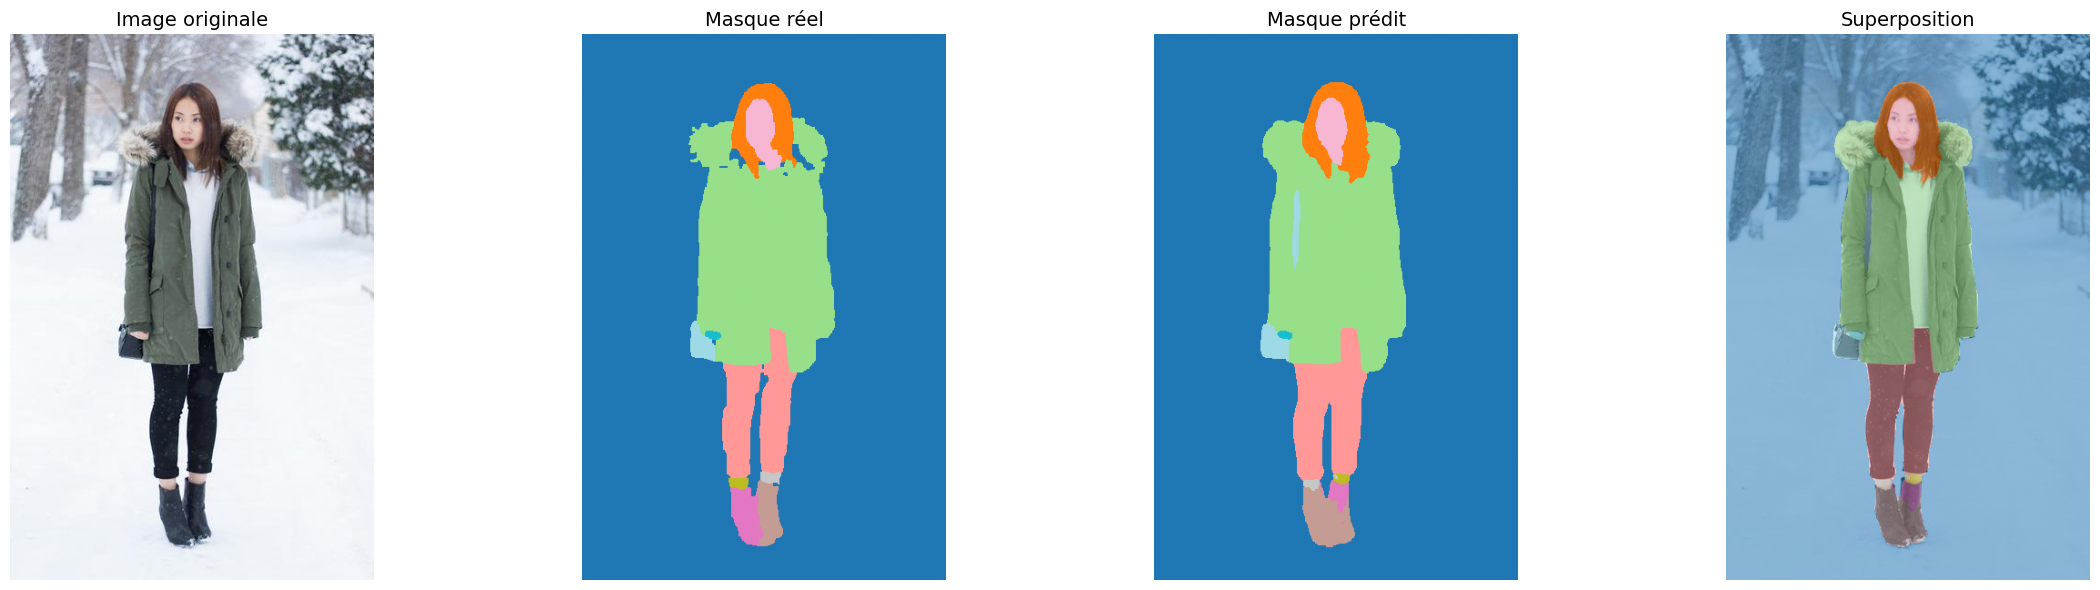

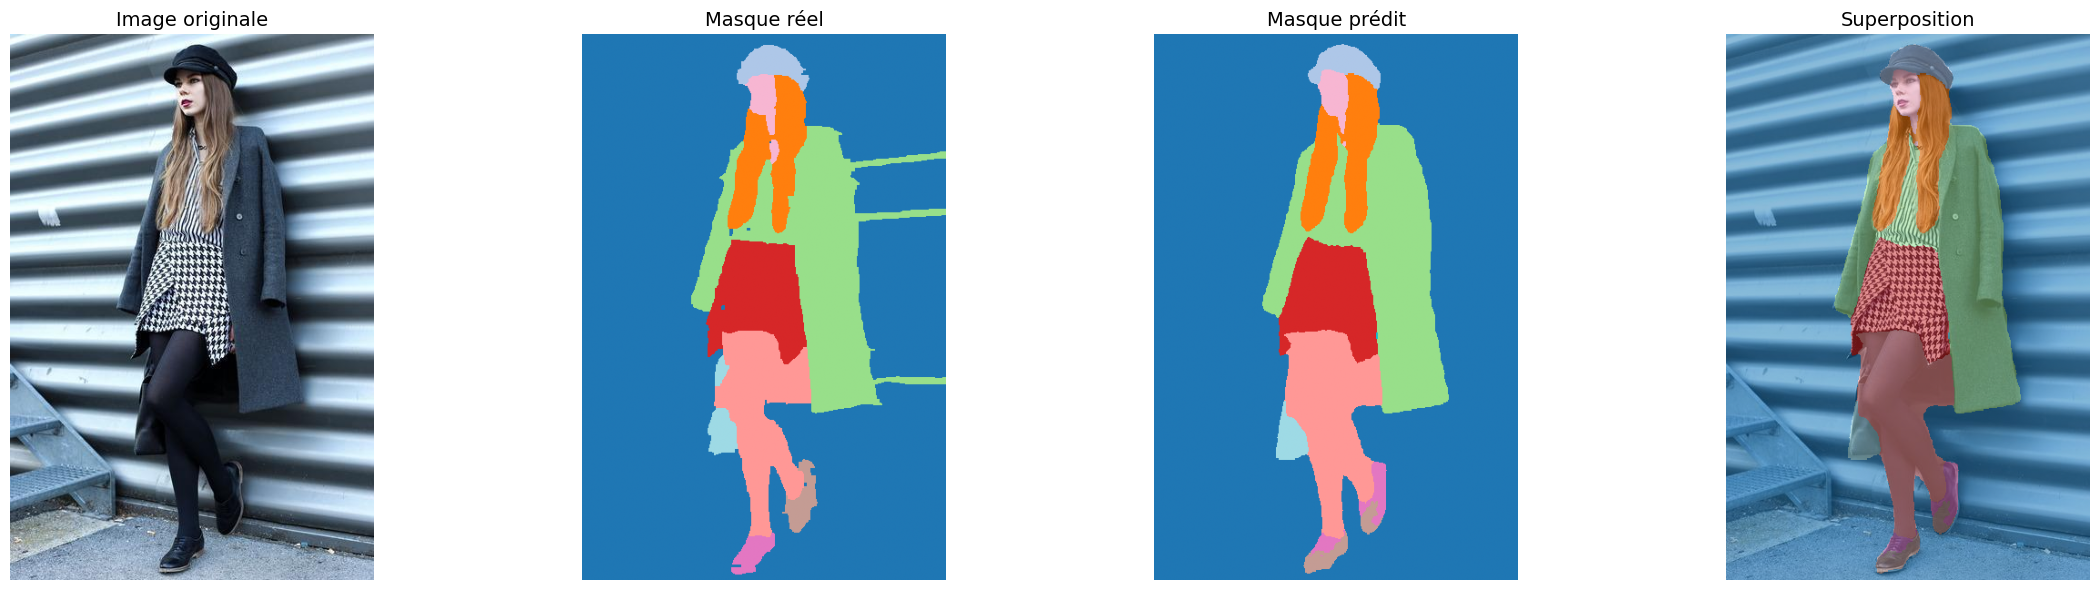

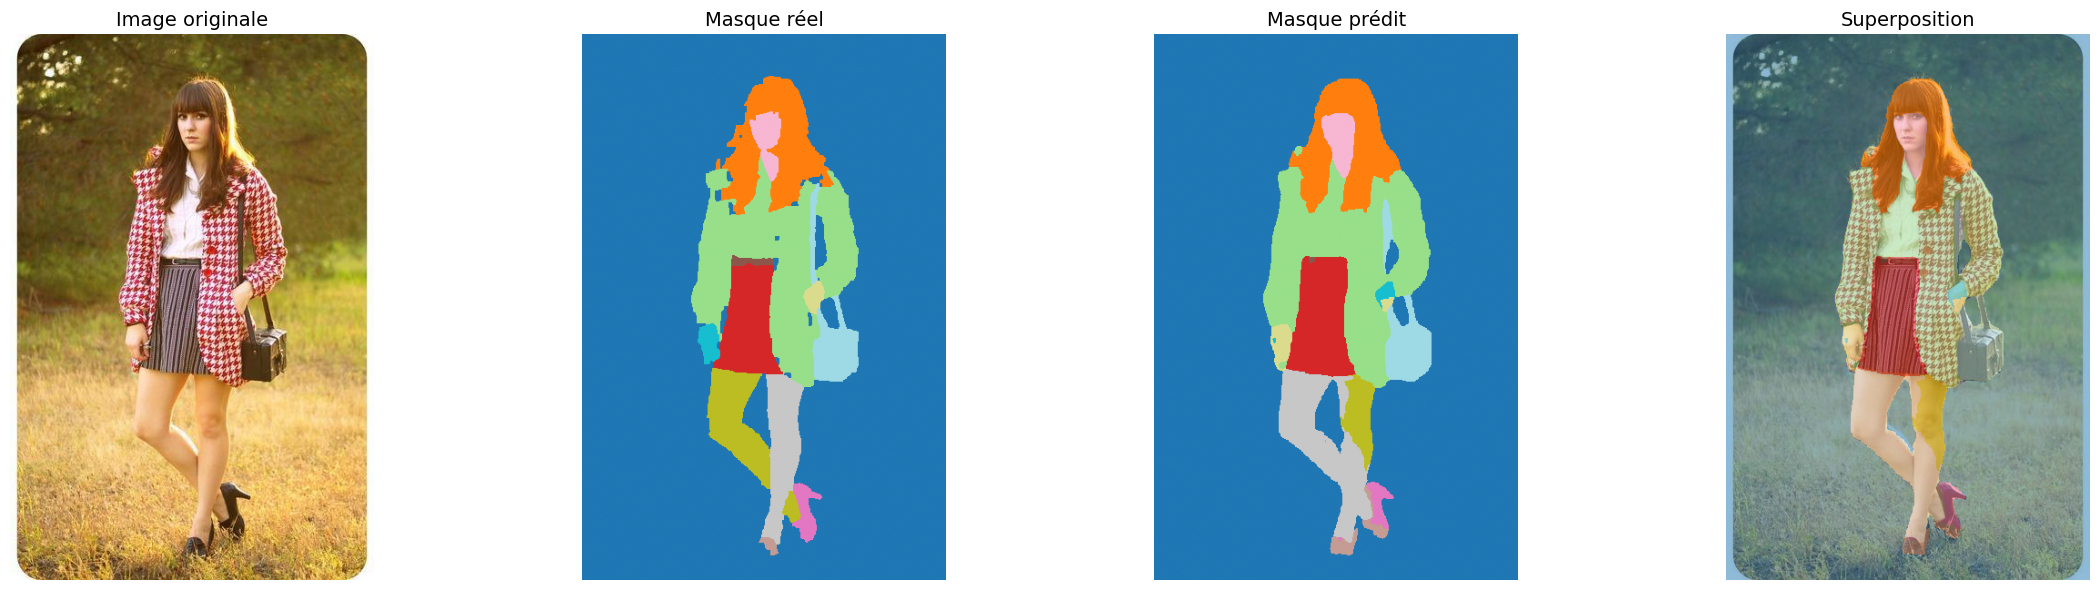

In [8]:
def display_segmented_images_batch(original_image_paths, segmentation_masks):
    """
    Affiche l'image originale, le masque réel, le masque prédit et la superposition.

    Args:
        original_image_paths (list): Liste des chemins des images originales.
        segmentation_masks (list): Liste des masques prédits (NumPy arrays).
    """
    for i, predicted_mask in enumerate(segmentation_masks):
        if i == max_images:
            break
        image = Image.open(original_image_paths[i])
        mask_reel = Image.open(mask_paths[i])

        if isinstance(predicted_mask, np.ndarray):

            fig, axs = plt.subplots(1, 4, figsize=(24, 6))

            # Image originale
            axs[0].imshow(image)
            axs[0].set_title("Image originale", fontsize=14)
            axs[0].axis("off")

            # Masque réel
            axs[1].imshow(mask_reel, cmap="tab20")
            axs[1].set_title("Masque réel", fontsize=14)
            axs[1].axis("off")

            # Masque prédit
            axs[2].imshow(predicted_mask, cmap="tab20")
            axs[2].set_title("Masque prédit", fontsize=14)
            axs[2].axis("off")

            # Superposition
            axs[3].imshow(image)
            axs[3].imshow(predicted_mask, alpha=0.5, cmap="tab20")
            axs[3].set_title("Superposition", fontsize=14)
            axs[3].axis("off")

            plt.tight_layout()
            plt.show()
        else:
            print(f"Masque prédit invalide pour l'image {original_image_paths[i]}")


# Afficher les résultats du batch
if batch_seg_results:
    display_segmented_images_batch(image_paths, batch_seg_results)
else:
    print("Aucun résultat de segmentation à afficher.")

## IoU

L’**IoU** (Intersection over Union) mesure le recouvrement entre le masque prédit du modèle et le masque réel pour chaque classe.

La formule de l’IoU est la suivante :

$$
\text{IoU} = \frac{|\text{Préd}(c) \cap \text{GT}(c)|}{|\text{Préd}(c) \cup \text{GT}(c)|}
$$

### Interprétation du résultat :

| IoU         | Interprétation                 |
|-------------|--------------------------------|
| 0.90–1.00   | Excellente segmentation        |
| 0.70–0.90   | Bonne segmentation             |
| 0.50–0.70   | Acceptable                     |
| < 0.50      | Mauvaise détection / confusion |


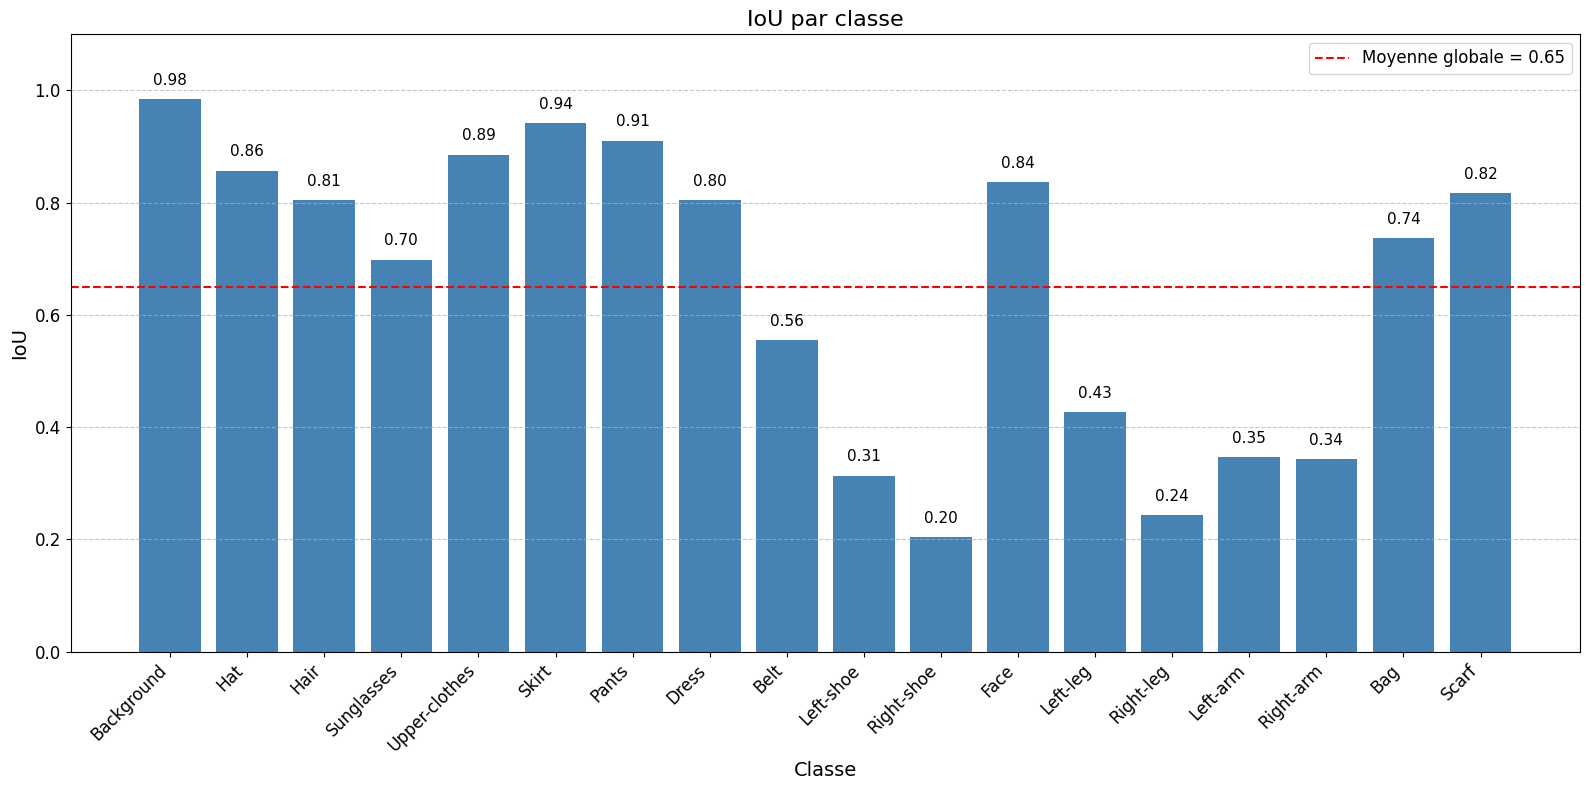

Moyenne IoU : 0.6504


In [14]:
# Convertir les masques réels en tableaux NumPy
y_trues = []
y_preds = []

for i, pred_mask in enumerate(batch_seg_results):
    if pred_mask is None:
        continue
    mask_real = np.array(Image.open(mask_paths[i]))
    if mask_real.shape != pred_mask.shape:
        mask_real = np.array(Image.fromarray(mask_real).resize(pred_mask.shape[::-1], Image.NEAREST))
    y_trues.append(mask_real.flatten())
    y_preds.append(pred_mask.flatten())

# Concaténer tous les pixels
y_true_all = np.concatenate(y_trues)
y_pred_all = np.concatenate(y_preds)

# Récupérer les classes présentes
all_classes = np.unique(np.concatenate((y_true_all, y_pred_all)))
iou_by_class = []

# Inverser le mapping ID -> nom
id_to_label = {v: k for k, v in CLASS_MAPPING.items()}
class_names = [id_to_label.get(int(c), f"Classe {int(c)}") for c in all_classes]

# Calcul IoU par classe
for cls in all_classes:
    intersection = np.logical_and(y_true_all == cls, y_pred_all == cls).sum()
    union = np.logical_or(y_true_all == cls, y_pred_all == cls).sum()
    if union == 0:
        iou = np.nan
    else:
        iou = intersection / union
    iou_by_class.append(iou)

# Moyenne globale
iou_mean = np.nanmean(iou_by_class)

# Affichage
plt.figure(figsize=(16, 8))
bars = plt.bar(class_names, iou_by_class, color="steelblue")
plt.axhline(y=iou_mean, color='red', linestyle='--', label=f"Moyenne globale = {iou_mean:.2f}")

# Annoter chaque barre avec la valeur
for bar, iou in zip(bars, iou_by_class):
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f"{iou:.2f}",
                 ha='center', va='bottom', fontsize=11)

plt.title("IoU par classe", fontsize=16)
plt.xlabel("Classe", fontsize=14)
plt.ylabel("IoU", fontsize=14)
plt.ylim(0, 1.1)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print(f"Moyenne IoU : {iou_mean:.4f}")

## Évaluation du modèle


- **IoU global :** 0.6504
- **Catégorie avec meilleure performance :** T-shirt
- **Catégorie la plus difficile :** Chaussures

Le modèle segmente correctement les vêtements larges ou bien définis (comme les hauts ou les pantalons), mais il rencontre des difficultés avec les éléments de petite taille ou fusionnant avec l’arrière-plan (chaussures, accessoires). On observe également une confusion fréquente entre les côtés gauche et droit (chaussure gauche/droite, jambe gauche/droite, etc.).


## Performances du modèle :

In [ ]:
print(f"Temps total de traitement : {total_time:.2f} secondes")
print(f"Temps moyen par image     : {avg_time:.2f} secondes/image")

Temps total de traitement : 100.87 secondes
Temps moyen par image     : 2.02 secondes/image


## Conclusion

- Le modèle segformer_b3 fournit de bonnes performances globales (IoU moyen = 0.65)
- Les vêtements centraux sont bien segmentés, les petits objets sont plus difficiles
- Le coût API est raisonnable pour un usage prototypal, mais doit être optimisé pour l'échelle

Pistes d'amélioration :
- Enrichir les données pour les petites classes
- Envisager un fine-tuning
